##### Till "3_chatbotWithLangGraph.ipynb", the LLM did not have access to any tools. So, If I ask it "What is the stock price of Google today, it can't tell, because LLMs have a knowledge cutoff date.
##### So, we give our LLM access to certain "tools" that it can call when needed, like Stock APIs. LLM makes the intelligent decision of which tool to call (ex: by reading the docstring etc. associated with the tools).

In [1]:
from langchain_core.tools import tool
from langchain.chat_models import init_chat_model
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
from dotenv import load_dotenv 
load_dotenv()  # take environment variables from .env file 

True

In [3]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

# A dummy tool, in real life, it would be replaced with actual APIs
# Notice the docstring, this is what the LM uses to know when to call which tool
@tool
def get_stock_price(symbol: str) -> float:
    '''Return the current price of a stock given the stock symbol
    :param symbol: one of  "MSFT", "AAPL", "AMZN" and "RIL"
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.3,
        "AAPL": 100.4,
        "AMZN": 150.0,
        "RIL": 87.6
    }.get(symbol, 0.0)

tools = [get_stock_price] # Include all the tools here as a list

# llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

In [4]:
# CHANGE from "5_chatbotWithToolAccess_Agentic.ipynb" 
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    # # NOTE: response does NOT contain the answer now! 
    # print("response:", response)
    # print('\n')
    return {"messages": [response]}

builder = StateGraph(State)

# Adding nodes to the graph
builder.add_node("chat_bot", chatbot) # Syntax: "<name of node>", <function that the node will execute>
builder.add_node("tools", ToolNode(tools))


# Adding edges to the graph
builder.add_edge(START, "chat_bot") # Syntax: <from node>, <to node>; START and END are special nodes. More specifically, the START Node is a special node that 
builder.add_conditional_edges("chat_bot", tools_condition)

builder.add_edge("tools", "chat_bot")

# CHANGE from "5_chatbotWithToolAccess_Agentic.ipynb" 
graph = builder.compile(checkpointer=memory)

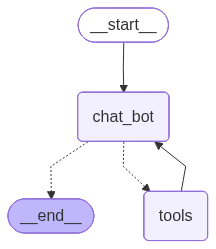

In [5]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### How to use langsmith to trace your llm calls

In [6]:
from langsmith import traceable

@traceable
def make_query(query):
    config1 = { 'configurable': { 'thread_id': '1'} }
    msg = query
    state = graph.invoke({"messages": [{"role": "user", "content": msg}]}, config=config1)
    print(state["messages"][-1].content)

In [7]:
make_query("What is the price of AAPL stock right now?")

The current price of AAPL stock is 100.4.


In [8]:
make_query("I want to buy 10 RIL stocks too! Add it to the previous total and let me know the new total cost? For the previous total, refer to the chat history till now.")

Okay, I see that the current price of AAPL stock is 100.4 and you want to buy 10 shares of RIL at 87.6 each.

The cost of 10 RIL stocks would be 10 * 87.6 = 876
Adding that to the cost of one AAPL stock, the new total cost would be 876 + 100.4 = 976.4


In [9]:
make_query("What did i ask you till now?")

Okay, here's a summary of what you've asked me so far:

1.  What is the price of AAPL stock right now?
2.  I want to buy 10 RIL stocks too! Add it to the previous total and let me know the new total cost? For the previous total, refer to the chat history till now.


### Now you can see all these calls to make_query() being traced in langsmith:
![Screenshot 2025-09-01 at 11.26.34 AM.png](<attachment:Screenshot 2025-09-01 at 11.26.34 AM.png>)
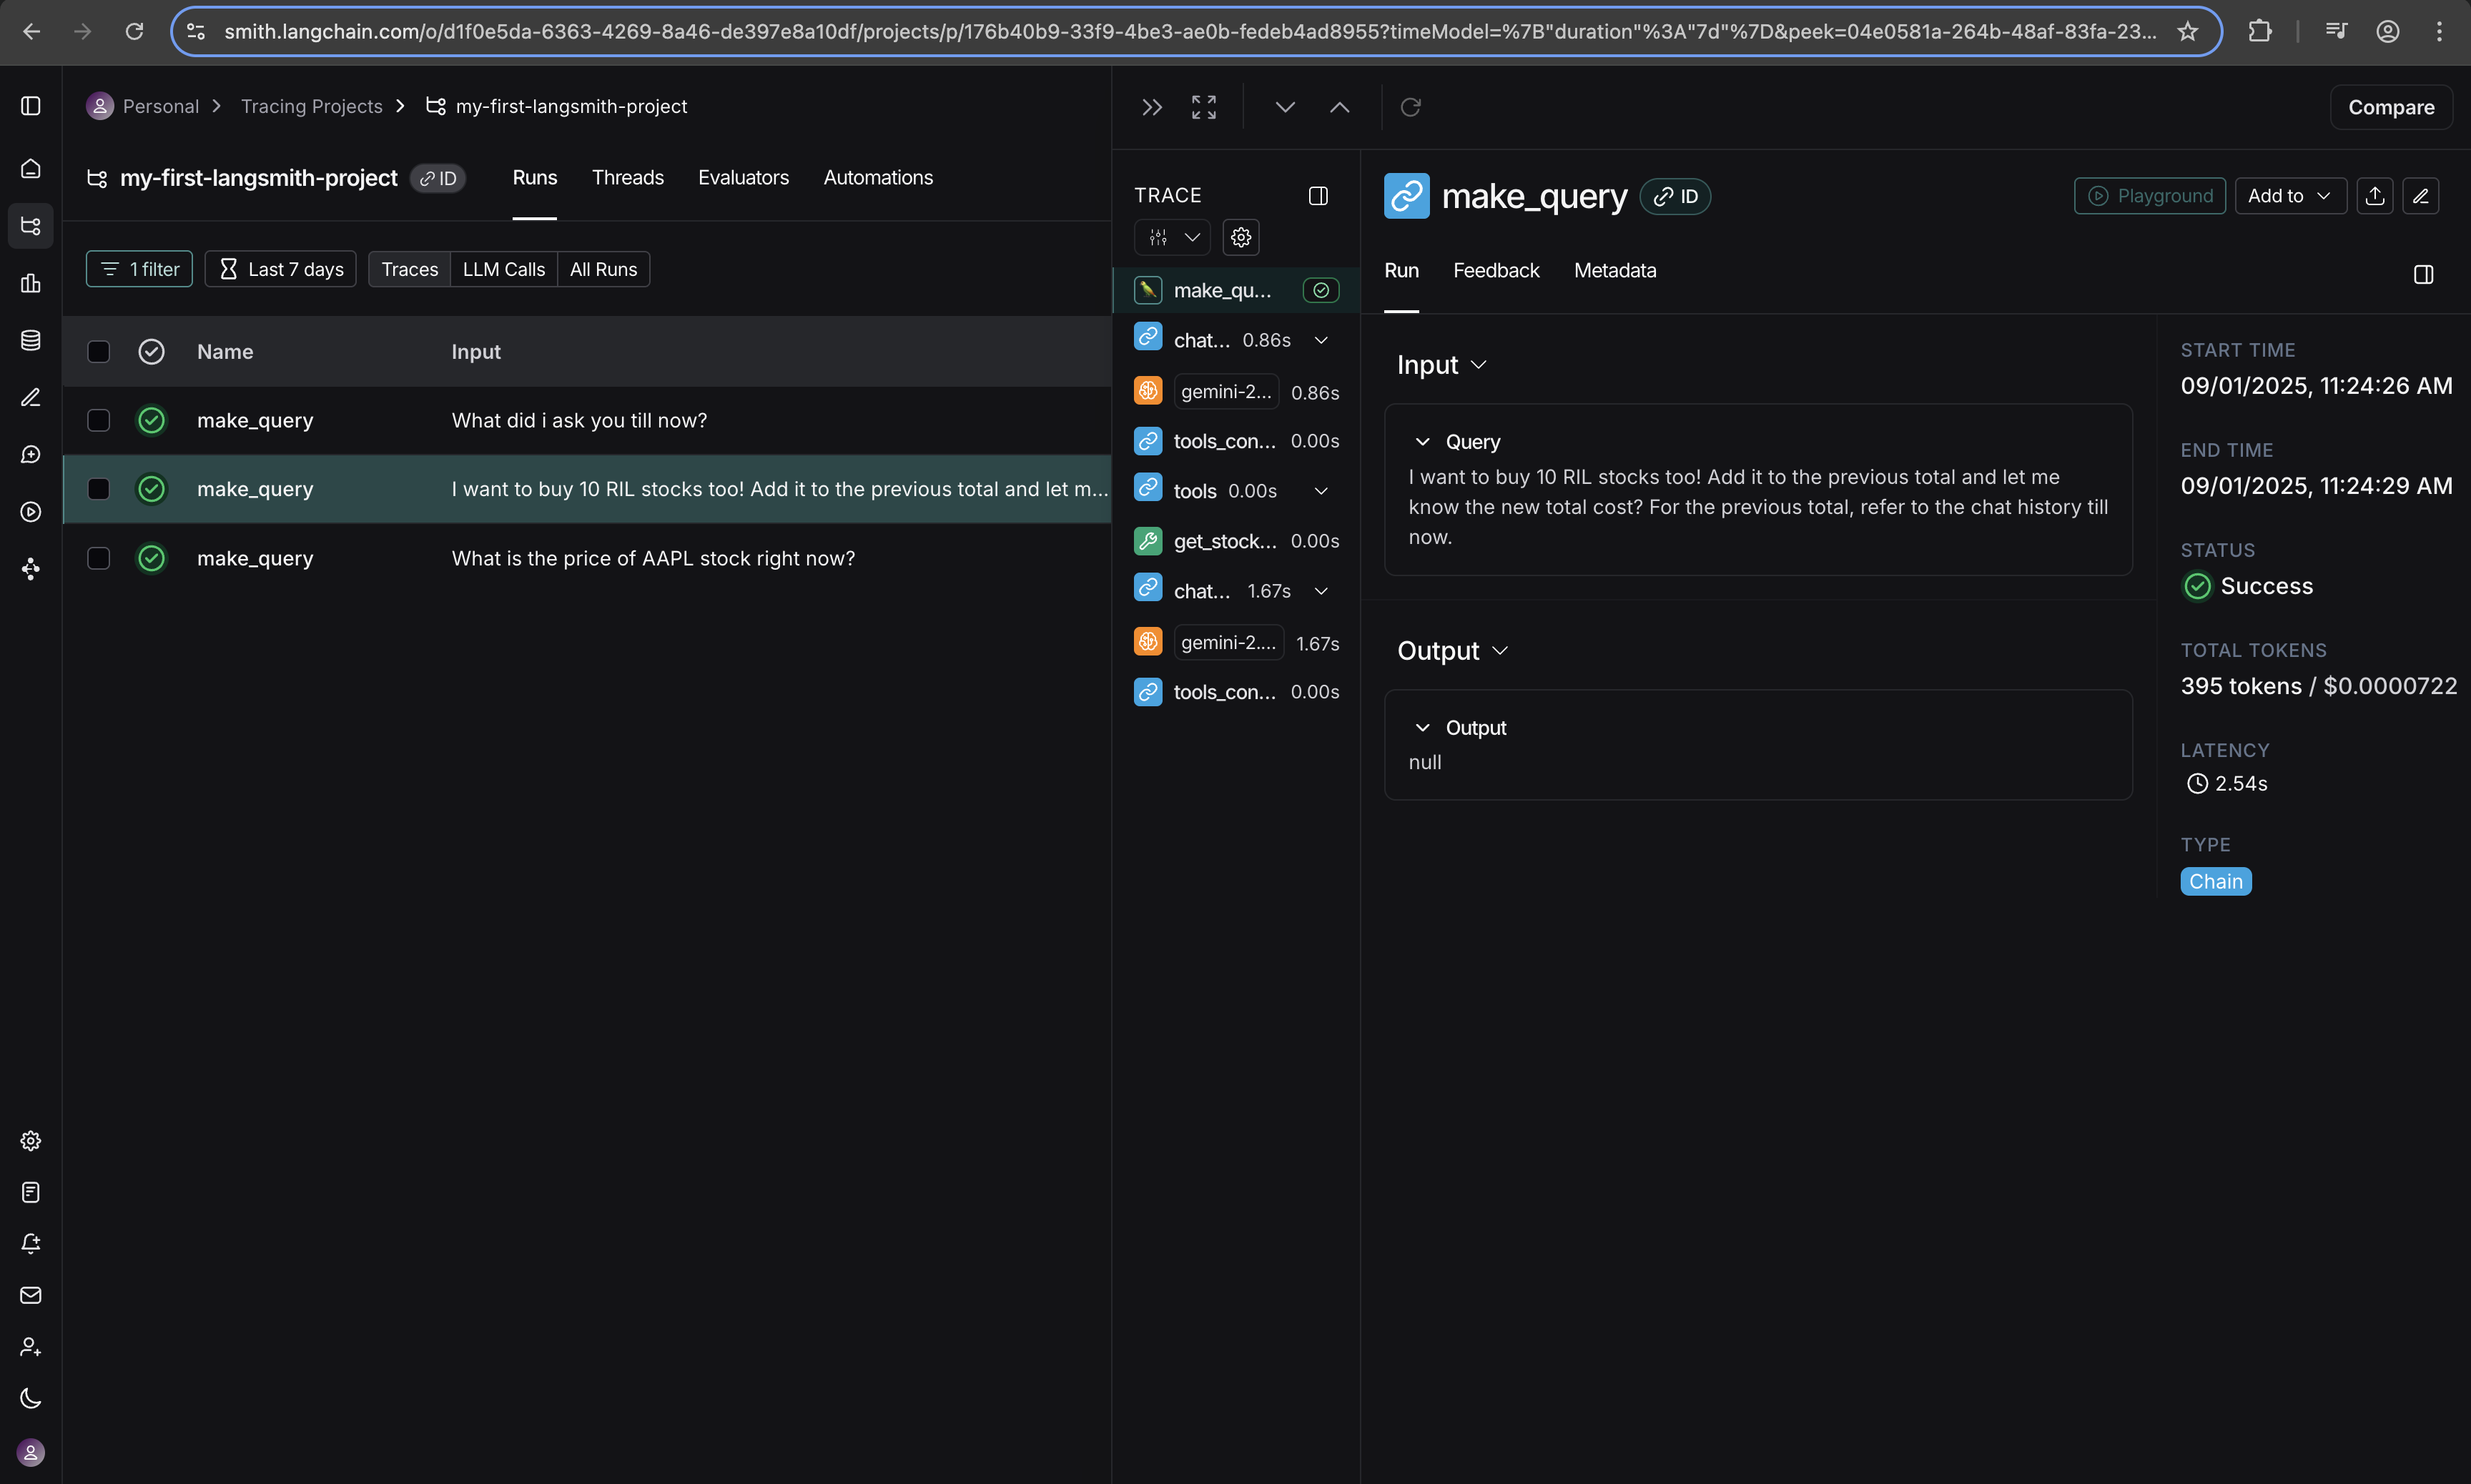